In [1]:
# Import dataset for MNIST
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import time
import math
np.random.seed(0)

Using TensorFlow backend.


In [2]:
# Load data in train and test splits
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [3]:
# We have 60k images with dimension 28x28 
train_images.shape

(60000, 28, 28)

In [0]:
# m = number of training examples
# h = height
# w = width 
m, h, w = train_images.shape

In [0]:
# Reshape the training and testing samples so that each image is represented as one 784 vector instead of 28x28 matrix 
train_images_flat = train_images.reshape((h*w, -1))
test_images_flat = test_images.reshape((h*w, -1))

In [6]:
# dimension of reshaped training images
train_images_flat.shape

(784, 60000)

In [7]:
# dimension of reshaped test images
test_images_flat.shape

(784, 10000)

In [0]:
# Normalize inputs
train_images_flat_normalized = train_images_flat.astype('float32') / 255
test_images_flat_normalized = test_images_flat.astype('float32') / 255

###**Function to initialize weights and bias**

In [0]:
# Initialize the Weights and Bias 
# Weighst are randomly initialized and have dimension (h*w, 1)
def initWightsAndBias(dim):

  weights = np.zeros(dim, )
  bias = 0
  
  return weights, bias

In [0]:
# Initialize the Weights and Bias for Softmax and Categorical Cross Entropy  
# Weighst are randomly initialized and have dimension (h*w, 1)
def initWightsAndBiasForSoftmax(dim):

  weights = np.zeros((dim, 10))
  bias = 0
  
  return weights, bias

###**Forward Pass**

In [0]:
# Calculate the logistic regression on input, weights and bias
def logisticRegression(x, weights, bias):
  result = np.dot(weights.T, x) + bias
  return result

In [0]:
# Calculate the sigmoid of result from logisticRegression
def sigmoid(z):
  return (1/(1 + np.exp(-z)))

In [0]:
# Calculate the softmax of the result from logisticRegression
def softmax(z):
  z -= np.max(z)
  return (np.exp(z) / np.sum(np.exp(z), axis = 0))

In [0]:
# Mean Squared Error: one of the Loss Functions for Logistic Regression
def MSE(a, y):
  return (np.sum(np.square(a - y) / (2. * len(y))))

In [0]:
# Binary Cross Entropy: One of the Loss Functions for Logistic Regression
def binaryCrossEntropy(a, y):
  # In order to avoid nan or inf errors while calculating the log, add a very small number, epsilon, to avoid calculating log of '0'
  epsilon = 1e-6
  aa = a + epsilon
  yy = y + epsilon
  logprobs = np.multiply(-np.log(aa),yy) + np.multiply(-np.log(1 - aa) , 1 - yy)
  loss = 1./m * np.nansum(logprobs)
  return loss

In [0]:
# Categorical Cross Entrop: Loss Function for Softmax Activation
def categoricalCrossEntropy(a, y):
  # Again, add epsilon to avoid calculating log of '0'
  epsilon = 1e-6
  aa = a + epsilon
  if len(y.shape) == 2:
    sz = y.shape[1]
  else:
    sz = 1
  return (-np.nansum(y * np.log(aa), axis = 1) / sz)

In [17]:
# Test Sigmoid
sigmoid(np.array([0, 2]))

array([0.5       , 0.88079708])

In [0]:
# Function to create labels for training and testing i.e., if a classifier is training for digit '0', then all other labels 
# will be '0' except the actual digit '0'
def createLabels(train_labels, test_labels, cls):
  y_train = [1 if x == cls else 0 for x in train_labels]
  y_test = [1 if x == cls else 0 for x in test_labels]
  
  return np.asarray(y_train), np.asarray(y_test)

###**Functions to update weights and bias depending on the type of Loss Function used**

In [0]:
# Gradient Calculation for the Mean Squared Error Function
def updateParamsMSE(a, y, x):
  dZ = (a - y) * a * (1 - a)/ float(m)
  if len(dZ) > 1:
    dW = 2 * np.dot(x, dZ.T)
  else:
    dW = x * dZ.T * 2
  db = 2 * np.sum(dZ, keepdims = True) / m

  return dW, db

In [0]:
# Gradient Calculation for the Binary Cross Entropy Function
def updateParamsBCE(a, y, x):
  dZ = (a - y) / float(m)
  if len(dZ) > 1:
    dW = np.dot(x, dZ)
  else:
    dW = x * dZ
  db = np.sum(dZ, keepdims = True) / m
  return dW, db

**Cross Entropy Loss Derivation is taken from these links: <br> https://www.ics.uci.edu/~pjsadows/notes.pdf <br> https://peterroelants.github.io/posts/cross-entropy-softmax/**

In [0]:
# Gradient Calculation for the Categorical Cross Entropy Function
def updateParamsCCE(a, y, x, bs):
  dZ = y - a
  dW = np.dot(x, dZ.T)
  db = np.sum(dZ, keepdims = True) / m
  return dW, db

In [0]:
# Extract Class Labels from softmax probabilities
def getClassLabels(a):
  return np.argmax(a, axis = 0)

###**This function represents a single logistic unit or neuron for processing inputs**

In [0]:
# Represents a basic Logistic Unit for Classification - that computes the logistic, 
# calculates loss and accuracy and then update the parameters
# This single unit is then used as many times as required for this homework 
def singleUnit(x, y, weights, bias, learningRate = 0.001, lossFunc = 'categoricalCrossEntropy', phase = 'train', bs = None):
    z = logisticRegression(x, weights, bias)
    a = None
    
    loss = 0.0
    acc = 0.0
    
    if lossFunc == 'MSE':
      a = sigmoid(z)
      a = np.array(a)
      for i in range(len(a)):
        if a[i] > 0.5:
          a[i] = 1
        else:
          a[i] = 0
      loss = MSE(a, y)
      acc = np.sum(a == y)
      acc = acc / float(len(y))
    elif lossFunc == 'binaryCrossEntropy':
      a = sigmoid(z)
      a = np.array(a)
      for i in range(len(a)):
        if a[i] > 0.5:
          a[i] = 1
        else:
          a[i] = 0
      loss = binaryCrossEntropy(a, y)
      acc = np.sum(a == y)
      acc = acc / float(len(y))
    elif lossFunc == 'categoricalCrossEntropy':
      a = softmax(z)
      loss = np.mean(categoricalCrossEntropy(a, y))
      sz = 0
      if len(y.shape) == 2:
        #print('a bef :', a)
        #print('a.shape: ', a.shape)
        sz = y.shape[1]
        aa = getClassLabels(a)
        yy = getClassLabels(y)
        acc += np.sum(aa == yy)
        #print('a: ', a)
        #for i in range(sz):
        #  acc += np.sum(a[:, i] == y[:, i])
      else:
        sz = 1
        aa = getClassLabels(a)
        yy = getClassLabels(y)
        acc += np.sum(aa == yy)
      acc /= sz
    dw = None
    db = None
    if phase == 'train':
      if lossFunc == 'MSE':
        
        dw, db = updateParamsMSE(a, y, x)
      elif lossFunc == 'binaryCrossEntropy':
        dw, db = updateParamsBCE(a, y, x)
      elif lossFunc == 'categoricalCrossEntropy':
        dw, db = updateParamsCCE(a, y, x, bs)
          
      weights = weights - (learningRate * dw)

      bias = bias - (learningRate * db)
      return loss, acc, weights, bias
    elif phase == 'test':
      if lossFunc == 'categoricalCrossEntropy':
        sz = 0
        if len(y.shape) == 2:
          sz = y.shape[1]
          aa = getClassLabels(a)
          yy = getClassLabels(y)
          acc += np.sum(aa == yy)
        else:
          sz = 1
          aa = getClassLabels(a)
          yy = getClassLabels(y)
          acc += np.sum(aa == yy)
        acc /= sz
      else: 
        acc = np.sum(a == y)
        acc = acc / float(len(y))
      return acc

##**Homework Problem 1 - Logistic Regression using Sigmoid Activation and Mean Squared Error**
### Following class implements Problem 1 of the Homework 
### using Gradient Descent, Stochastic Gradient Descent and Mini-batch Gradient Descent

In [0]:
# 
# Class Model that represents a model for training and testing 
# 

class Model():
  
  # Initialize the model and parameters of model
  def __init__(self, x, y, units = 10):
    # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
    self.classifiers = {}
    self.units = units
    self.x = x
    self.y = y
    
    # Initialize weights and biases for each unit. Each unit will have same weights and bias initially.
    weights, bias = initWightsAndBias(h * w)
    
    for unit in range(0, self.units):
      # Get Labels for Training and Testing for every unit - so if a unit represents digit '0', the '0' will be '1' in
      # the labels and others will be treated as non-zero and are represented as '0'
      trainLabels, testLabels = createLabels(train_labels, test_labels, unit)
      
      # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
      self.classifiers['c' + str(unit)] = {'loss': 0.0, 'acc': 0.0, 'weights': weights, 'bias': bias, 
                                      'trainLabels': trainLabels, 'testLabels': testLabels}
  
  # Initialize every unit in the model
  def initUnits(self, x, y):
    # Initialize weights and biases for each unit. Each unit will have same weights and bias initially.
    weights, bias = initWightsAndBias(h * w)
    self.x = x
    self.y = y
    
    for unit in range(0, self.units):
      # Get Labels for Training and Testing for every unit - so if a unit represents digit '0', the '0' will be '1' in
      # the labels and others will be treated as non-zero and are represented as '0'
      trainLabels, testLabels = createLabels(train_labels, test_labels, unit)
      
      # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
      self.classifiers['c' + str(unit)] = {'loss': 0.0, 'acc': 0.0, 'weights': weights, 'bias': bias, 
                                      'trainLabels': trainLabels, 'testLabels': testLabels}
  
  def checkWeights(self, no):
    for key in self.classifiers.keys():
      print('Weights for Classifier for {}: {}'.format(key, self.classifiers[key][2][0: no]))

  def train(self, x, y, epochs = 10, units = 10, learningRate = 1e-3, lossFunc = None, optimizer = None, batchSize = None):
    print('Training started...')
    weights, bias = initWightsAndBias(h * w)
    # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
    
    # If the optimizer is GD (Gradient Descent) - train all classifiers on all images (60K) in each epoch
    # If the optimizer is SGD (Stochastic Gradient Descent) - train each classifier on each image in each epoch
    # If the optimizer is MGD (Mini-batch Gradient Descent) - train each classifier on mini-batch in each epoch
    startTime = time.time()
    if optimizer == 'GD':
      print('Running GD')
      for epoch in range(1, epochs + 1):
        print('Epoch: {}'.format(epoch))
        for key in self.classifiers.keys():
          loss, acc, weights, bias = singleUnit(self.x, self.classifiers[key]['trainLabels'], self.classifiers[key]['weights'], 
                                                self.classifiers[key]['bias'], lossFunc = 'MSE', phase = 'train')
          
          self.classifiers[key]['loss'] = loss
          self.classifiers[key]['acc'] = acc
          self.classifiers[key]['weights'] = weights[:]
          self.classifiers[key]['bias'] = bias
          print('Classifier for digit {} --> Loss: {:.4f}, Acc: {:.4f}'.format(key, loss, acc))
        #print('len: ', self.classifiers['c0']['weights'][0:20])
          
          
    elif optimizer == 'SGD':
      print('Running SGD')
      for epoch in range(1, epochs + 1):
        print('Epoch: {}'.format(epoch))
        for i in range(0, m):
          for key in self.classifiers.keys():
            loss, acc, weights, bias = singleUnit(self.x[:,i], self.classifiers[key]['trainLabels'][i:i+1], self.classifiers[key]['weights'], 
                                                  self.classifiers[key]['bias'], lossFunc = 'MSE', phase = 'train')
            
            self.classifiers[key]['loss'] += loss
            self.classifiers[key]['acc'] += acc
            self.classifiers[key]['weights'] = weights
            self.classifiers[key]['bias'] = bias
      for key in self.classifiers.keys():
        print('Classifier for digit {} --> Loss: {:.4f}, Acc: {:.4f}'.format(key, self.classifiers[key]['loss']/(epochs * m), 
                                                                             self.classifiers[key]['acc']/(epochs * m)))
            
    elif optimizer == 'MGD' and batchSize is not None:
      print('Running MGD')
      batches = math.ceil(m / batchSize)
      start = 0
      end = batchSize
      for epoch in range(1, epochs + 1):
        print('Epoch: {}'.format(epoch))
        for i in range(1, batches + 1):
          print('Batch {} of {}'.format(i, batches))
          for key in self.classifiers.keys():
            loss, acc, weights, bias = singleUnit(self.x[:, start:end], self.classifiers[key]['trainLabels'][start:end], self.classifiers[key]['weights'], 
                                                  self.classifiers[key]['bias'], lossFunc = 'MSE', phase = 'train')
            self.classifiers[key]['loss'] = loss
            self.classifiers[key]['acc'] = acc
            self.classifiers[key]['weights'] = weights
            self.classifiers[key]['bias'] = bias
            print('Classifier for digit {} --> Loss: {:.4f}, Acc: {:.4f}'.format(key, self.classifiers[key]['loss'], self.classifiers[key]['acc']))
          start = end
          end = start + batchSize
          if end > m:
            end = m
    print('Training Time: {:.04}'.format ((time.time() - startTime)))
  
  def test(self, x, y):
    print('Testing the model...')
    listAcc = []
    for key in self.classifiers.keys():
      acc = singleUnit(x, y, self.classifiers[key]['weights'], self.classifiers[key]['bias'], lossFunc = 'MSE', phase = 'test')
      #print('Acc: ', acc)
      listAcc.append(acc)
    digit = np.argmax(np.array(listAcc))
    maxAcc = np.max(np.array(listAcc))
      
    print('Accuracy: {}'.format(maxAcc * 100)) 

In [0]:
# Assign flattened and normalized images to x
x = train_images_flat_normalized
y = train_labels
x_test = test_images_flat_normalized
y_test = test_labels
# Initialize model with 10 units
model = Model(x, y, 10)

# Initialize model parameters 
#model.initUnits(x, y)

In [102]:
# Train and Test the model with Gradient Descent
classifiers = model.train(x, y, epochs = 3, units = 10, learningRate = 1e-3, lossFunc = 'MSE', optimizer = 'GD', batchSize = None)

Training started...
Running GD
Epoch: 1
Classifier for digit c0 --> Loss: 0.0494, Acc: 0.9013
Classifier for digit c1 --> Loss: 0.0562, Acc: 0.8876
Classifier for digit c2 --> Loss: 0.0496, Acc: 0.9007
Classifier for digit c3 --> Loss: 0.0511, Acc: 0.8978
Classifier for digit c4 --> Loss: 0.0487, Acc: 0.9026
Classifier for digit c5 --> Loss: 0.0452, Acc: 0.9096
Classifier for digit c6 --> Loss: 0.0493, Acc: 0.9014
Classifier for digit c7 --> Loss: 0.0522, Acc: 0.8956
Classifier for digit c8 --> Loss: 0.0488, Acc: 0.9025
Classifier for digit c9 --> Loss: 0.0496, Acc: 0.9009
Epoch: 2
Classifier for digit c0 --> Loss: 0.0494, Acc: 0.9013
Classifier for digit c1 --> Loss: 0.0562, Acc: 0.8876
Classifier for digit c2 --> Loss: 0.0496, Acc: 0.9007
Classifier for digit c3 --> Loss: 0.0511, Acc: 0.8978
Classifier for digit c4 --> Loss: 0.0487, Acc: 0.9026
Classifier for digit c5 --> Loss: 0.0452, Acc: 0.9096
Classifier for digit c6 --> Loss: 0.0493, Acc: 0.9014
Classifier for digit c7 --> Loss:

In [31]:
# Train the model with Stochastic Gradient Descent
model.train(x, y, epochs = 1, units = 10, learningRate = 1e-3, lossFunc = 'MSE', optimizer = 'SGD', batchSize = None)

Training started...
Running SGD
Epoch: 1
Classifier for digit c0 --> Loss: 0.0494, Acc: 0.9013
Classifier for digit c1 --> Loss: 0.0562, Acc: 0.8876
Classifier for digit c2 --> Loss: 0.0497, Acc: 0.9007
Classifier for digit c3 --> Loss: 0.0511, Acc: 0.8978
Classifier for digit c4 --> Loss: 0.0487, Acc: 0.9026
Classifier for digit c5 --> Loss: 0.0452, Acc: 0.9097
Classifier for digit c6 --> Loss: 0.0493, Acc: 0.9014
Classifier for digit c7 --> Loss: 0.0522, Acc: 0.8956
Classifier for digit c8 --> Loss: 0.0488, Acc: 0.9025
Classifier for digit c9 --> Loss: 0.0496, Acc: 0.9009
Training Time: 45.98


In [36]:
# Train the model with Mini Batch Gradient Descent
model.train(x, y, epochs = 1, units = 10, learningRate = 1e-3, lossFunc = 'MSE', optimizer = 'MGD', batchSize = 256)

Training started...
Running MGD
Epoch: 1
Batch 1 of 235
Classifier for digit c0 --> Loss: 0.0586, Acc: 0.8828
Classifier for digit c1 --> Loss: 0.0684, Acc: 0.8633
Classifier for digit c2 --> Loss: 0.0488, Acc: 0.9023
Classifier for digit c3 --> Loss: 0.0586, Acc: 0.8828
Classifier for digit c4 --> Loss: 0.0469, Acc: 0.9062
Classifier for digit c5 --> Loss: 0.0332, Acc: 0.9336
Classifier for digit c6 --> Loss: 0.0469, Acc: 0.9062
Classifier for digit c7 --> Loss: 0.0508, Acc: 0.8984
Classifier for digit c8 --> Loss: 0.0371, Acc: 0.9258
Classifier for digit c9 --> Loss: 0.0508, Acc: 0.8984
Batch 2 of 235
Classifier for digit c0 --> Loss: 0.0391, Acc: 0.9219
Classifier for digit c1 --> Loss: 0.0664, Acc: 0.8672
Classifier for digit c2 --> Loss: 0.0527, Acc: 0.8945
Classifier for digit c3 --> Loss: 0.0430, Acc: 0.9141
Classifier for digit c4 --> Loss: 0.0547, Acc: 0.8906
Classifier for digit c5 --> Loss: 0.0469, Acc: 0.9062
Classifier for digit c6 --> Loss: 0.0430, Acc: 0.9141
Classifier 

In [37]:
# Test the model
xTest = test_images_flat_normalized
yTest = test_labels
model.test(xTest, yTest)

Accuracy: 9.8


##**Homework Problem 2 - Logistic Regression using Sigmoid Activation and Binary Cross Entropy Loss Function **
### Following class implements Problem 2 of the Homework
### using Gradient Descent, Stochastic Gradient Descent and Mini-batch Gradient Descent

In [0]:
# 
# Class Model2 that represents a model for training and testing 
# 

class Model2():
  
  # Initialize the model and parameters of model
  def __init__(self, x, y, units = 10):
    # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
    self.classifiers = {}
    self.units = units
    self.x = x
    self.y = y
    
    # Initialize weights and biases for each unit. Each unit will have same weights and bias initially.
    weights, bias = initWightsAndBias(h * w)
    
    for unit in range(0, self.units):
      # Get Labels for Training and Testing for every unit - so if a unit represents digit '0', the '0' will be '1' in
      # the labels and others will be treated as non-zero and are represented as '0'
      trainLabels, testLabels = createLabels(train_labels, test_labels, unit)
      
      # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
      self.classifiers['c' + str(unit)] = {'loss': 0.0, 'acc': 0.0, 'weights': weights, 'bias': bias, 
                                      'trainLabels': trainLabels, 'testLabels': testLabels}
  
  # Initialize every unit in the model
  def initUnits(self, x, y):
    # Initialize weights and biases for each unit. Each unit will have same weights and bias initially.
    weights, bias = initWightsAndBias(h * w)
    self.x = x
    self.y = y
    
    for unit in range(0, self.units):
      # Get Labels for Training and Testing for every unit - so if a unit represents digit '0', the '0' will be '1' in
      # the labels and others will be treated as non-zero and are represented as '0'
      trainLabels, testLabels = createLabels(train_labels, test_labels, unit)
      
      # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
      self.classifiers['c' + str(unit)] = {'loss': 0.0, 'acc': 0.0, 'weights': weights, 'bias': bias, 
                                      'trainLabels': trainLabels, 'testLabels': testLabels}
  
  def checkWeights(self, no):
    for key in self.classifiers.keys():
      print('Weights for Classifier for {}: {}'.format(key, self.classifiers[key][2][0: no]))

  def train(self, x, y, epochs = 10, units = 10, learningRate = 1e-3, lossFunc = None, optimizer = None, batchSize = None):
    print('Training started...')
    weights, bias = initWightsAndBias(h * w)
    # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
    
    # If the optimizer is GD (Gradient Descent) - train all classifiers on all images (60K) in each epoch
    # If the optimizer is SGD (Stochastic Gradient Descent) - train each classifier on each image in each epoch
    # If the optimizer is MGD (Mini-batch Gradient Descent) - train each classifier on mini-batch in each epoch
    startTime = time.time()
    if optimizer == 'GD':
      print('Running GD')
      for epoch in range(1, epochs + 1):
        print('Epoch: {}'.format(epoch))
        for key in self.classifiers.keys():
          loss, acc, weights, bias = singleUnit(self.x, self.classifiers[key]['trainLabels'], self.classifiers[key]['weights'], 
                                                self.classifiers[key]['bias'], lossFunc = 'binaryCrossEntropy', phase = 'train')
          self.classifiers[key]['loss'] = loss
          self.classifiers[key]['acc'] = acc
          self.classifiers[key]['weights'] = weights[:]
          self.classifiers[key]['bias'] = bias
          print('Classifier for digit {} --> Loss: {:.4f}, Acc: {:.4f}'.format(key, loss, acc))
        #print('len: ', self.classifiers['c0']['weights'][0:20])
          
          
    elif optimizer == 'SGD':
      print('Running SGD')
      for epoch in range(1, epochs + 1):
        print('Epoch: {}'.format(epoch))
        for i in range(0, m):
          for key in self.classifiers.keys():
            loss, acc, weights, bias = singleUnit(self.x[:,i], self.classifiers[key]['trainLabels'][i:i+1], self.classifiers[key]['weights'], 
                                                  self.classifiers[key]['bias'], lossFunc = 'binaryCrossEntropy', phase = 'train')
            
            self.classifiers[key]['loss'] += loss
            self.classifiers[key]['acc'] += acc
            self.classifiers[key]['weights'] = weights
            self.classifiers[key]['bias'] = bias
      for key in self.classifiers.keys():
        print('Classifier for digit {} --> Loss: {:.4f}, Acc: {:.4f}'.format(key, self.classifiers[key]['loss']/(epochs * m), 
                                                                             self.classifiers[key]['acc']/(epochs * m)))
            
    elif optimizer == 'MGD' and batchSize is not None:
      print('Running MGD')
      batches = math.ceil(m / batchSize)
      start = 0
      end = batchSize
      for epoch in range(1, epochs + 1):
        print('Epoch: {}'.format(epoch))
        for i in range(1, batches + 1):
          print('Batch {} of {}'.format(i, batches))
          for key in self.classifiers.keys():
            xBatch = self.x[:, start:end]
            yBatch = self.y[start:end]
            loss, acc, weights, bias = singleUnit(xBatch, yBatch, self.classifiers[key]['weights'], 
                                                  self.classifiers[key]['bias'], lossFunc = 'binaryCrossEntropy', phase = 'train')
            self.classifiers[key]['loss'] = loss
            self.classifiers[key]['acc'] = acc
            self.classifiers[key]['weights'] = weights
            self.classifiers[key]['bias'] = bias
            print('Classifier for digit {} --> Loss: {:.4f}, Acc: {:.4f}'.format(key, self.classifiers[key]['loss'], self.classifiers[key]['acc']))
          start = end
          end = start + batchSize
          if end > m:
            end = m
    print('Training Time: {:.04}'.format ((time.time() - startTime)))
    
    #print('len: ', self.classifiers['c0']['weights'][0:20])
  
  def test(self, x, y):
    listAcc = []
    for key in self.classifiers.keys():
      acc = singleUnit(x, y, self.classifiers[key]['weights'], self.classifiers[key]['bias'], lossFunc = 'MSE', phase = 'test')
      #print('Acc: ', acc)
      listAcc.append(acc)
    digit = np.argmax(np.array(listAcc))
    maxAcc = np.max(np.array(listAcc))
      
    print('Accuracy: {}'.format(maxAcc * 100))

  

In [0]:
# Assign flattened and normalized images to x
x = train_images_flat_normalized
y = train_labels
# Initialize model with 10 units
model2 = Model2(x, y, 10)

In [105]:
# Train the model with Gradient Descent
model2.train(x, y, epochs = 3, units = 10, learningRate = 1e-3, lossFunc = 'binaryCrossEntropy', optimizer = 'GD', batchSize = None)

Training started...
Running GD
Epoch: 1
Classifier for digit c0 --> Loss: 1.3638, Acc: 0.9013
Classifier for digit c1 --> Loss: 1.5524, Acc: 0.8876
Classifier for digit c2 --> Loss: 1.3719, Acc: 0.9007
Classifier for digit c3 --> Loss: 1.4117, Acc: 0.8978
Classifier for digit c4 --> Loss: 1.3452, Acc: 0.9026
Classifier for digit c5 --> Loss: 1.2482, Acc: 0.9096
Classifier for digit c6 --> Loss: 1.3627, Acc: 0.9014
Classifier for digit c7 --> Loss: 1.4426, Acc: 0.8956
Classifier for digit c8 --> Loss: 1.3473, Acc: 0.9025
Classifier for digit c9 --> Loss: 1.3698, Acc: 0.9009
Epoch: 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


Classifier for digit c0 --> Loss: 0.0000, Acc: 0.0987
Classifier for digit c1 --> Loss: 0.0000, Acc: 0.1124
Classifier for digit c2 --> Loss: 0.0000, Acc: 0.0993
Classifier for digit c3 --> Loss: 0.0000, Acc: 0.1022
Classifier for digit c4 --> Loss: 0.0000, Acc: 0.0974
Classifier for digit c5 --> Loss: 0.0000, Acc: 0.0903
Classifier for digit c6 --> Loss: 0.0000, Acc: 0.0986
Classifier for digit c7 --> Loss: 0.0000, Acc: 0.1044
Classifier for digit c8 --> Loss: 0.0000, Acc: 0.0975
Classifier for digit c9 --> Loss: 0.0000, Acc: 0.0992
Epoch: 3
Classifier for digit c0 --> Loss: 1.3638, Acc: 0.9013
Classifier for digit c1 --> Loss: 1.5524, Acc: 0.8876
Classifier for digit c2 --> Loss: 1.3719, Acc: 0.9007
Classifier for digit c3 --> Loss: 1.4117, Acc: 0.8978
Classifier for digit c4 --> Loss: 1.3452, Acc: 0.9026
Classifier for digit c5 --> Loss: 1.2482, Acc: 0.9096
Classifier for digit c6 --> Loss: 1.3627, Acc: 0.9014
Classifier for digit c7 --> Loss: 1.4426, Acc: 0.8956
Classifier for digi

In [106]:
# Train the model with Gradient Descent
model2.train(x, y, epochs = 1, units = 10, learningRate = 1e-3, lossFunc = 'binaryCrossEntropy', optimizer = 'SGD', batchSize = None)

Training started...
Running SGD
Epoch: 1
Classifier for digit c0 --> Loss: 0.0000, Acc: 0.9013
Classifier for digit c1 --> Loss: 0.0001, Acc: 0.8876
Classifier for digit c2 --> Loss: 0.0000, Acc: 0.9007
Classifier for digit c3 --> Loss: 0.0000, Acc: 0.8978
Classifier for digit c4 --> Loss: 0.0000, Acc: 0.9026
Classifier for digit c5 --> Loss: 0.0000, Acc: 0.9097
Classifier for digit c6 --> Loss: 0.0000, Acc: 0.9014
Classifier for digit c7 --> Loss: 0.0000, Acc: 0.8956
Classifier for digit c8 --> Loss: 0.0000, Acc: 0.9025
Classifier for digit c9 --> Loss: 0.0000, Acc: 0.9009
Training Time: 57.25


In [107]:
# Train the model with Mini Batch Gradient Descent
model2.train(x, y, epochs = 1, units = 10, learningRate = 1e-3, lossFunc = 'binaryCrossEntropy', optimizer = 'MGD', batchSize = 256)

Training started...
Running MGD
Epoch: 1
Batch 1 of 235
Classifier for digit c0 --> Loss: 0.2459, Acc: 0.1172
Classifier for digit c1 --> Loss: 0.2459, Acc: 0.1172
Classifier for digit c2 --> Loss: 0.2459, Acc: 0.1172
Classifier for digit c3 --> Loss: 0.2459, Acc: 0.1172
Classifier for digit c4 --> Loss: 0.2459, Acc: 0.1172
Classifier for digit c5 --> Loss: 0.2459, Acc: 0.1172
Classifier for digit c6 --> Loss: 0.2459, Acc: 0.1172
Classifier for digit c7 --> Loss: 0.2459, Acc: 0.1172
Classifier for digit c8 --> Loss: 0.2459, Acc: 0.1172
Classifier for digit c9 --> Loss: 0.2459, Acc: 0.1172
Batch 2 of 235
Classifier for digit c0 --> Loss: 0.2653, Acc: 0.0781
Classifier for digit c1 --> Loss: 0.2653, Acc: 0.0781
Classifier for digit c2 --> Loss: 0.2653, Acc: 0.0781
Classifier for digit c3 --> Loss: 0.2653, Acc: 0.0781
Classifier for digit c4 --> Loss: 0.2653, Acc: 0.0781
Classifier for digit c5 --> Loss: 0.2653, Acc: 0.0781
Classifier for digit c6 --> Loss: 0.2653, Acc: 0.0781
Classifier 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


Classifier for digit c6 --> Loss: 0.0000, Acc: 0.1328
Classifier for digit c7 --> Loss: 0.0000, Acc: 0.1328
Classifier for digit c8 --> Loss: 0.0032, Acc: 0.1406
Classifier for digit c9 --> Loss: 0.0000, Acc: 0.1328
Batch 35 of 235
Classifier for digit c0 --> Loss: 0.0000, Acc: 0.0898
Classifier for digit c1 --> Loss: 0.0000, Acc: 0.0898
Classifier for digit c2 --> Loss: 0.0000, Acc: 0.0898
Classifier for digit c3 --> Loss: 0.0000, Acc: 0.0898
Classifier for digit c4 --> Loss: 0.0000, Acc: 0.0898
Classifier for digit c5 --> Loss: 0.0051, Acc: 0.0859
Classifier for digit c6 --> Loss: 0.0000, Acc: 0.0898
Classifier for digit c7 --> Loss: 0.0000, Acc: 0.0898
Classifier for digit c8 --> Loss: 0.0000, Acc: 0.0898
Classifier for digit c9 --> Loss: 0.0000, Acc: 0.0898
Batch 36 of 235
Classifier for digit c0 --> Loss: 0.0000, Acc: 0.1133
Classifier for digit c1 --> Loss: 0.0000, Acc: 0.1133
Classifier for digit c2 --> Loss: 0.0000, Acc: 0.1133
Classifier for digit c3 --> Loss: 0.0000, Acc: 0.1

In [108]:
# Test the model
xTest = test_images_flat_normalized
yTest = test_labels
model2.test(xTest, yTest)

Accuracy: 11.35


##**Homework Problem 3 - Logistic Regression using Softmax Activation and Categorical Cross Entropy Loss Function **
### Following class implements Problem 3 of the Homework
### using Gradient Descent, Stochastic Gradient Descent and Mini-batch Gradient Descent

In [0]:
from keras.utils import to_categorical

In [0]:
# 
# Class Model3 that represents a model for training and testing 
# 

class Model3():
  
  # Initialize the model and parameters of model
  def __init__(self, x, y, units = 10):
    # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
    self.classifiers = {}
    self.units = units
    self.x = x
    self.y = y
    
    # Initialize weights and biases for each unit. Each unit will have same weights and bias initially.
    weights, bias = initWightsAndBiasForSoftmax(h * w)
    
    for unit in range(0, self.units):
      
      # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
      self.classifiers['c' + str(unit)] = {'loss': 0.0, 'acc': 0.0, 'weights': weights, 'bias': bias, 
                                      'trainLabels': y, 'testLabels': []}
  
  # Initialize every unit in the model
  def initUnits(self, x, y):
    # Initialize weights and biases for each unit. Each unit will have same weights and bias initially.
    weights, bias = initWightsAndBiasForSoftmax(h * w)
    self.x = x
    self.y = y
    
    for unit in range(0, self.units):
      
      # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
      self.classifiers['c' + str(unit)] = {'loss': 0.0, 'acc': 0.0, 'weights': weights, 'bias': bias, 
                                      'trainLabels': y, 'testLabels': testLabels}
  
  def checkWeights(self, no):
    for key in self.classifiers.keys():
      print('Weights for Classifier for {}: {}'.format(key, self.classifiers[key]['weights'][0: no]))

  def train(self, x, y, epochs = 10, units = 10, learningRate = 0.001, lossFunc = None, optimizer = None, batchSize = None):
    print('Training started...')
    weights, bias = initWightsAndBiasForSoftmax(h * w)
    # Dictonary to hold the tuple (loss, accuracy, weights, bias, train_labels, test_labels) for each classifier 
    
    # If the optimizer is GD (Gradient Descent) - train all classifiers on all images (60K) in each epoch
    # If the optimizer is SGD (Stochastic Gradient Descent) - train each classifier on each image in each epoch
    # If the optimizer is MGD (Mini-batch Gradient Descent) - train each classifier on mini-batch in each epoch
    startTime = time.time()
    if optimizer == 'GD':
      print('Running GD')
      for epoch in range(1, epochs + 1):
        print('Epoch: {}'.format(epoch))
        for key in self.classifiers.keys():
          loss, acc, weights, bias = singleUnit(self.x, self.y, self.classifiers[key]['weights'], 
                                                self.classifiers[key]['bias'], lossFunc = lossFunc, phase = 'train', bs = m)
          self.classifiers[key]['loss'] = loss
          self.classifiers[key]['acc'] = acc
          self.classifiers[key]['weights'] = weights[:]
          self.classifiers[key]['bias'] = bias
          print('Classifier for digit {} --> Loss: {:.4f}, Acc: {:.4f}'.format(key, loss, acc))
          
          
    elif optimizer == 'SGD':
      print('Running SGD')
      for epoch in range(1, epochs + 1):
        print('Epoch: {}'.format(epoch))
        for i in range(0, m):
          for key in self.classifiers.keys():
            x1 = self.x[:,i]
            y1 = self.y[:,i]
            
            loss, acc, weights, bias = singleUnit(x1, y1, weights = self.classifiers[key]['weights'], 
                                                  bias = self.classifiers[key]['bias'], lossFunc = lossFunc, phase = 'train', bs = 1)
            
            self.classifiers[key]['loss'] += loss
            self.classifiers[key]['acc'] += acc
            self.classifiers[key]['weights'] = weights
            self.classifiers[key]['bias'] = bias
            break
            
      for key in self.classifiers.keys():
        print('Classifier for digit {} --> Loss: {:.4f}, Acc: {:.4f}'.format(key, self.classifiers[key]['loss']/(epochs * m), 
                                                                             self.classifiers[key]['acc']/(epochs * m)))
            
    elif optimizer == 'MGD' and batchSize is not None:
      print('Running MGD')
      print('bs: ', batchSize)
      batches = math.ceil(m / batchSize)
      start = 0
      end = batchSize
      for epoch in range(1, epochs + 1):
        print('Epoch: {}'.format(epoch))
        for i in range(1, batches + 1):
          print('Batch {} of {}'.format(i, batches))
          for key in self.classifiers.keys():
            xBatch = self.x[:, start:end]
            yBatch = self.y[:, start:end]
            loss, acc, weights, bias = singleUnit(xBatch, yBatch, self.classifiers[key]['weights'], 
                                                  self.classifiers[key]['bias'], lossFunc = lossFunc, phase = 'train', bs = batchSize)
            self.classifiers[key]['loss'] = loss
            self.classifiers[key]['acc'] = acc
            self.classifiers[key]['weights'] = weights
            self.classifiers[key]['bias'] = bias
            print('Classifier for digit {} --> Loss: {:.4f}, Acc: {:.4f}'.format(key, self.classifiers[key]['loss'], self.classifiers[key]['acc']))
            
          start = end
          end = start + batchSize
          if end > m:
            end = m
    print('Training Time: {:.04}'.format ((time.time() - startTime)))
    
  
  def test(self, x, y):
    listAcc = []
    for key in self.classifiers.keys():
      acc = singleUnit(x, y, self.classifiers[key]['weights'], self.classifiers[key]['bias'], lossFunc = 'categoricalCrossEntropy', phase = 'test')
      #print('Acc: ', acc)
      listAcc.append(acc)
    digit = np.argmax(np.array(listAcc))
    maxAcc = np.max(np.array(listAcc))
      
    print('Test Accuracy: {}'.format(maxAcc * 100))

In [0]:
# Assign flattened and normalized images to x
x = train_images_flat_normalized
# Convert training labels to categorical labels
y = to_categorical(train_labels)
y = y.reshape(y.shape[1], y.shape[0])

# Initialize model with 10 units
model3 = Model3(x, y, 10)

In [75]:
# Train the model with Gradient Descent
model3.train(x, y, epochs = 5, units = 10, learningRate = 1e-3, lossFunc = 'categoricalCrossEntropy', optimizer = 'GD')

Training started...
Running GD
Epoch: 1
Classifier for digit c0 --> Loss: 0.2303, Acc: 0.4482
Classifier for digit c1 --> Loss: 0.2303, Acc: 0.4482
Classifier for digit c2 --> Loss: 0.2303, Acc: 0.4482
Classifier for digit c3 --> Loss: 0.2303, Acc: 0.4482
Classifier for digit c4 --> Loss: 0.2303, Acc: 0.4482
Classifier for digit c5 --> Loss: 0.2303, Acc: 0.4482
Classifier for digit c6 --> Loss: 0.2303, Acc: 0.4482
Classifier for digit c7 --> Loss: 0.2303, Acc: 0.4482
Classifier for digit c8 --> Loss: 0.2303, Acc: 0.4482
Classifier for digit c9 --> Loss: 0.2303, Acc: 0.4482
Epoch: 2
Classifier for digit c0 --> Loss: 0.2412, Acc: 0.1250
Classifier for digit c1 --> Loss: 0.2412, Acc: 0.1250
Classifier for digit c2 --> Loss: 0.2412, Acc: 0.1250
Classifier for digit c3 --> Loss: 0.2412, Acc: 0.1250
Classifier for digit c4 --> Loss: 0.2412, Acc: 0.1250
Classifier for digit c5 --> Loss: 0.2412, Acc: 0.1250
Classifier for digit c6 --> Loss: 0.2412, Acc: 0.1250
Classifier for digit c7 --> Loss:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Classifier for digit c0 --> Loss: 1.1012, Acc: 0.1115
Classifier for digit c1 --> Loss: 1.1012, Acc: 0.1115
Classifier for digit c2 --> Loss: 1.1012, Acc: 0.1115
Classifier for digit c3 --> Loss: 1.1012, Acc: 0.1115
Classifier for digit c4 --> Loss: 1.1012, Acc: 0.1115
Classifier for digit c5 --> Loss: 1.1012, Acc: 0.1115
Classifier for digit c6 --> Loss: 1.1012, Acc: 0.1115
Classifier for digit c7 --> Loss: 1.1012, Acc: 0.1115
Classifier for digit c8 --> Loss: 1.1012, Acc: 0.1115
Classifier for digit c9 --> Loss: 1.1012, Acc: 0.1115
Training Time: 35.13


In [87]:
# Train the model with Mini Batch Gradient Descent
model3.train(x, y, epochs = 1, units = 10, learningRate = 1e-3, lossFunc = 'categoricalCrossEntropy', optimizer = 'MGD', batchSize = 256)

Training started...
Running MGD
bs:  256
Epoch: 1
Batch 1 of 235
Classifier for digit c0 --> Loss: 0.2294, Acc: 0.4531
Classifier for digit c1 --> Loss: 0.2294, Acc: 0.4531
Classifier for digit c2 --> Loss: 0.2294, Acc: 0.4531
Classifier for digit c3 --> Loss: 0.2294, Acc: 0.4531
Classifier for digit c4 --> Loss: 0.2294, Acc: 0.4531
Classifier for digit c5 --> Loss: 0.2294, Acc: 0.4531
Classifier for digit c6 --> Loss: 0.2294, Acc: 0.4531
Classifier for digit c7 --> Loss: 0.2294, Acc: 0.4531
Classifier for digit c8 --> Loss: 0.2294, Acc: 0.4531
Classifier for digit c9 --> Loss: 0.2294, Acc: 0.4531
Batch 2 of 235
Classifier for digit c0 --> Loss: 0.2311, Acc: 0.0938
Classifier for digit c1 --> Loss: 0.2311, Acc: 0.0938
Classifier for digit c2 --> Loss: 0.2311, Acc: 0.0938
Classifier for digit c3 --> Loss: 0.2311, Acc: 0.0938
Classifier for digit c4 --> Loss: 0.2311, Acc: 0.0938
Classifier for digit c5 --> Loss: 0.2311, Acc: 0.0938
Classifier for digit c6 --> Loss: 0.2311, Acc: 0.0938
Cl

In [88]:
x_test = test_images_flat_normalized
y_test = to_categorical(test_labels)
y_test = y_test.reshape(y_test.shape[1], y_test.shape[0])
model3.test(x_test, y_test)

Test Accuracy: 5.310530999999999


##**Homework Problem 4 - Logistic Regression using Softmax Activation and Categorical Cross Entropy Loss Function **
### Implemented using Keras

In [39]:
# Problem 4
# Network from Problem 3 reimplemented in Keras
from keras import models
from keras import layers

(trainSet, trainLabels), (testSet, testLabels) = mnist.load_data()

trainSet = trainSet.reshape((60000, 28 * 28))
trainSet = trainSet.astype('float32') / 255

testSet = testSet.reshape((10000, 28 * 28))
testSet = testSet.astype('float32') / 255


trainLabels = to_categorical(trainLabels)
testLabels = to_categorical(testLabels)

model = models.Sequential()
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 5

history = model.fit(trainSet, trainLabels, epochs = epochs, validation_data = (testSet, testLabels))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 119us/step - loss: 0.7684 - acc: 0.8200 - val_loss: 0.4804 - val_acc: 0.8824
Epoch 2/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.4563 - acc: 0.8801 - val_loss: 0.4000 - val_acc: 0.8958
Epoch 3/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.4033 - acc: 0.8909 - val_loss: 0.3683 - val_acc: 0.8994
Epoch 4/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.3768 - acc: 0.8967 - val_loss: 0.3487 - val_acc: 0.9038
Epoch 5/5
60000/60000 [==============================] - 6s 102us/step - loss: 0.3601 - acc: 0.9006 - val_loss: 0.3357 - val_acc: 0.9078


In [0]:
import matplotlib.pyplot as plt
def plot(epochs, history):
  
  plt.figure(figsize=(14, 8))
  plt.subplot(221)
  plt.plot([x for x in range(0, epochs)], history.history['loss'], 'r-', label='Training Loss')
  plt.plot([x for x in range(0, epochs)], history.history['val_loss'], 'b-', label='Validation Loss')
  plt.xlabel('#Epochs')
  plt.ylabel('Loss')
  plt.legend()
  
  plt.subplot(222)
  plt.plot([x for x in range(0, epochs)], history.history['acc'], 'r-', label='Training Accuracy')
  plt.plot([x for x in range(0, epochs)], history.history['val_acc'], 'b-', label='Validation Accuracy')
  plt.xlabel('#Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  
  plt.show()
  

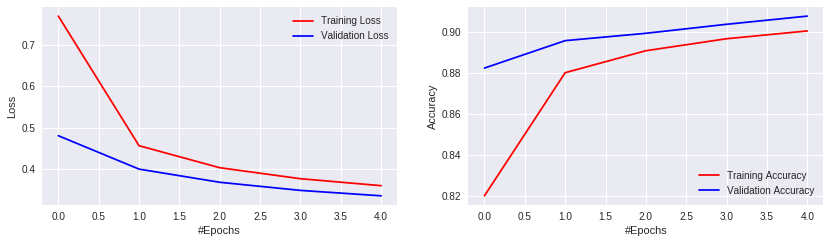

In [41]:
plot(epochs, history)

##**Homework Problem 5 - Feature Addition using Connected Components Algorithm **
### Implemented using Keras

In [0]:
# Treat Train Images as Graph of 28 x 28 Adjacency List and find out Connected Components using DFS Algorithm
class Graph: 
  def __init__(self, rows, cols, graph): 
    self.rows = row 
    self.cols = col 
    self.graph = graph
  def isSafe(self, i, j, visited):
    return (i >= 0 and i < self.rows and j >= 0 and j < self.cols and not visited[i][j] and self.graph[i][j])            
  def DFS(self, i, j, visited):
    rowNbr = [-1, -1, -1,  0, 0,  1, 1, 1]; 
    colNbr = [-1,  0,  1, -1, 1, -1, 0, 1]; 
    visited[i][j] = True
    for k in range(8):
      if self.isSafe(i + rowNbr[k], j + colNbr[k], visited):
        self.DFS(i + rowNbr[k], j + colNbr[k], visited) 
  def connectedComponents(self):
    visited = [[False for j in range(self.cols)]for i in range(self.rows)] 
    count = 0
    for i in range(self.rows):
      for j in range(self.cols):
        if visited[i][j] == False and self.graph[i][j] == 1:
          self.DFS(i, j, visited)
          count += 1
    return count

In [0]:
train_images_final = train_images.reshape((60000, 28 * 28))
train_images_final = train_images_final.astype('float32') / 255

test_images_final = test_images.reshape((10000, 28 * 28))
test_images_final = test_images_final.astype('float32') / 255

**Create a matrix to store images in binary form i.e., convert every white/non-zero pixel to zero and every black pixel to 1 so we can find the connected components** 

In [0]:
train_images_binary = np.zeros((60000,28,28))
for counter, a in enumerate(train_images):
  for j, b in enumerate(a):
    for k, c in enumerate(b):
      if (c == 0):
        train_images_binary[counter, j, k] = 1
      elif (c != 0):
        train_images_binary[counter, j, k] = 0

In [0]:
test_images_binary = np.zeros((10000,28,28))
for counter, a in enumerate(test_images):
  for j, b in enumerate(a):
    for k, c in enumerate(b):
      if (c == 0):
        test_images_binary[counter, j, k] = 1
      elif (c != 0):
        test_images_binary[counter, j, k] = 0

In [0]:
components = []
for a in train_images_binary:
  row = len(a)
  col = len(a[0])
  g = Graph(row, col, a)
  components.append(g.connectedComponents())

In [0]:
test_components = []
for a in test_images_binary:
  row = len(a)
  col = len(a[0])
  g = Graph(row, col, a)
  test_components.append(g.connectedComponents())

In [0]:
train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

**Convert components list to numpy array and expand dimension for axis '0' so we can add #connected components to images**

In [15]:
compArr = np.array(components)
print(compArr.shape)
compArr = np.expand_dims(compArr, 0)
print(compArr.shape)

(60000,)
(1, 60000)


In [22]:
test_compArr = np.array(test_components)
print(test_compArr.shape)
test_compArr = np.expand_dims(test_compArr, 0)
print(test_compArr.shape)

(10000,)
(1, 10000)


**Append the connected components features to images **

In [43]:
# append new feature to training images
train_x = train_images_flat_normalized
print('Shape before append: ', train_x.shape)
train_x = np.append(train_x, compArr, axis = 0)
print('Shape after append: ', train_x.shape)

Shape before append:  (784, 60000)
Shape after append:  (785, 60000)


In [42]:
# append new feature to test images
test_x = test_images_flat_normalized
print('Shape before append: ', test_x.shape)
test_x = np.append(test_x, test_compArr, axis = 0)
print('Shape after append: ', test_x.shape)

Shape before append:  (784, 10000)
Shape after append:  (785, 10000)


In [0]:
# Create model in Keras
from keras import models
from keras import layers
network = models.Sequential()
network.add(layers.Dense(10, input_shape=(785,), activation='softmax'))

In [0]:
network.compile(optimizer='SGD',loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
epochs = 10
history = network.fit(train_x.T, 
                      train_labels_cat, 
                      epochs=epochs, 
                      batch_size=256, 
                      validation_data=(test_x.T, test_labels_cat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 41us/step - loss: 1.9600 - acc: 0.2578 - val_loss: 1.9864 - val_acc: 0.2405
Epoch 2/10
60000/60000 [==============================] - 2s 41us/step - loss: 1.9540 - acc: 0.2597 - val_loss: 1.9816 - val_acc: 0.2400
Epoch 3/10
60000/60000 [==============================] - 2s 41us/step - loss: 1.9483 - acc: 0.2616 - val_loss: 1.9767 - val_acc: 0.2426
Epoch 4/10
60000/60000 [==============================] - 2s 41us/step - loss: 1.9430 - acc: 0.2632 - val_loss: 1.9723 - val_acc: 0.2420
Epoch 5/10
60000/60000 [==============================] - 2s 41us/step - loss: 1.9380 - acc: 0.2645 - val_loss: 1.9682 - val_acc: 0.2441
Epoch 6/10
60000/60000 [==============================] - 2s 41us/step - loss: 1.9333 - acc: 0.2657 - val_loss: 1.9645 - val_acc: 0.2446
Epoch 7/10
60000/60000 [==============================] - 2s 41us/step - loss: 1.9287 - acc: 0.2665 - val_loss: 1.9611 - val_acc

In [0]:
import matplotlib.pyplot as plt
def plot(epochs, history):
  
  plt.figure(figsize=(14, 8))
  plt.subplot(221)
  plt.plot([x for x in range(0, epochs)], history.history['loss'], 'r-', label='Training Loss')
  plt.plot([x for x in range(0, epochs)], history.history['val_loss'], 'b-', label='Validation Loss')
  plt.xlabel('#Epochs')
  plt.ylabel('Loss')
  plt.legend()
  
  plt.subplot(222)
  plt.plot([x for x in range(0, epochs)], history.history['acc'], 'r-', label='Training Accuracy')
  plt.plot([x for x in range(0, epochs)], history.history['val_acc'], 'b-', label='Validation Accuracy')
  plt.xlabel('#Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  
  plt.show()

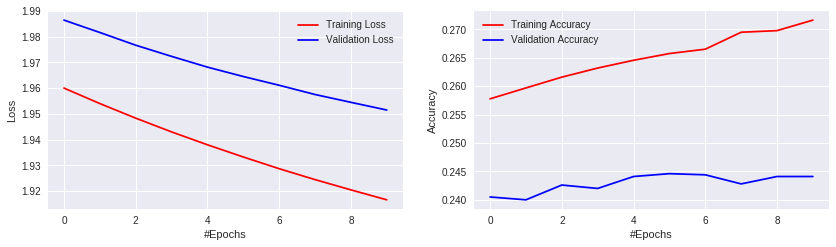

In [69]:
plot(epochs, history)